<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [16]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

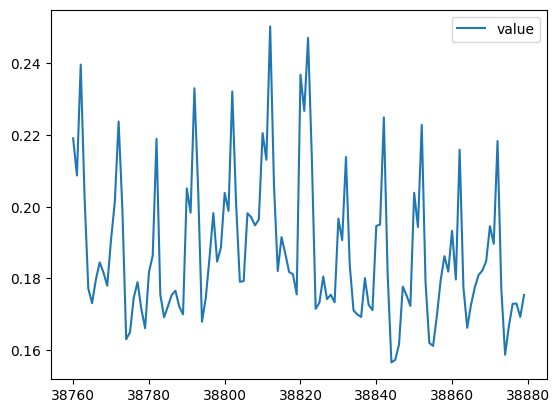

In [17]:
data[-120:].plot()

In [18]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [19]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [20]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [21]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 10
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [22]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [23]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [24]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [25]:
torch.manual_seed(42)

In [26]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 27.888311619124217 %
smape 10.646649918883865 %
smape 10.82715747474927 %
smape 10.017254829668163 %
smape 9.461014946563202 %
smape 9.211477735324909 %
smape 9.170024804988799 %
smape 9.414323374019032 %
smape 9.596469753928352 %
smape 9.635023101292855 %
smape 9.841214896816956 %
smape 9.882440078153945 %
smape 9.842112435147776 %
smape 9.767788495672376 %
smape 9.588804824049014 %
smape 9.647368662364302 %
smape 9.556959491027028 %
smape 9.503759246384888 %
smape 9.575297840767437 %
smape 9.805046725168562 %
smape 9.792160802678755 %
smape 9.892982705033313 %
smape 9.828500965098192 %
smape 9.676992144239577 %
smape 9.66918099780529 %
smape 9.55380886488142 %
smape 9.809847370835772 %
smape 9.815741919896059 %
smape 9.43910879611272 %
smape 9.285621321515034 %
smape 9.40989014436627 %
smape 9.232234522613169 %
smape 9.125422109027355 %
smape 9.301201780462822 %
smape 9.406793423389134 %
smape 9.62141478662951 %
smape 9.63911582677685 %
smape 9.413329151551626 %
smape 9.0672954

In [27]:
torch.manual_seed(42)

In [28]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [29]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.4075890558679021 %
SMAPE 4.113010478555225 %
SMAPE 0.5303946787307723 %
SMAPE 0.27534668600856094 %
SMAPE 0.3733976040384732 %
SMAPE 1.1192544003060902 %
SMAPE 1.0278208243871632 %
SMAPE 0.06831113418229506 %
SMAPE 0.6668714070599435 %
SMAPE 0.6202113151861965 %
SMAPE 0.934543654400386 %
SMAPE 0.1175353850828742 %
SMAPE 0.49471358618029626 %
SMAPE 0.4479480968539065 %
SMAPE 0.4093138307944173 %
SMAPE 0.6971483988454565 %
SMAPE 0.42817360297431156 %
SMAPE 2.149804265615785 %
SMAPE 0.2374832019850146 %
SMAPE 0.38436462328286325 %
SMAPE 2.449757142618182 %
SMAPE 0.22371528919831007 %
SMAPE 1.6756879713720991 %
SMAPE 0.9281276784020066 %
SMAPE 2.208827259761165 %
SMAPE 1.1176862899810658 %
SMAPE 0.578006195697526 %
SMAPE 0.5261109220277831 %
SMAPE 0.481160336013545 %
SMAPE 0.23144692678397405 %
SMAPE 0.4630786910565803 %
SMAPE 0.5285498882271895 %
SMAPE 0.6690164250321686 %
SMAPE 0.5392439980887502 %
SMAPE 0.5248749532693182 %
SMAPE 0.23782954501803036 %
SMAPE 0.18601399562385268 %

SMAPE 0.7429282278571918 %
SMAPE 0.543003972009501 %
SMAPE 0.4429941910536854 %
SMAPE 1.1876561261278766 %
SMAPE 0.11515655167204386 %
SMAPE 1.4641949446886429 %
SMAPE 0.17113276047427917 %
SMAPE 0.16091654344199924 %
SMAPE 1.1623162617497655 %
SMAPE 1.9281259481804227 %
SMAPE 1.768839394011593 %
SMAPE 0.7555090449714044 %
SMAPE 8.912318501570553 %
SMAPE 3.390177612393017 %
SMAPE 0.0846523857981083 %
SMAPE 1.4697303986322368 %
SMAPE 0.49404305930875125 %
SMAPE 0.484808465851529 %
SMAPE 0.10169404991563623 %
SMAPE 0.38049920242929147 %
SMAPE 0.6787555156452072 %
SMAPE 0.10297533565176309 %
SMAPE 0.4490082809497835 %
SMAPE 0.1626112145989964 %
SMAPE 0.8267316070687228 %
SMAPE 1.0234835096316601 %
SMAPE 1.6830990271764676 %
SMAPE 0.7225329401217095 %
SMAPE 0.14447911470017516 %
SMAPE 1.943200634880185 %
SMAPE 1.343870646202049 %
SMAPE 0.19945987362916642 %
SMAPE 0.4628662145041745 %
SMAPE 0.2995224425694687 %
SMAPE 0.6530639688062365 %
SMAPE 0.5287129448261112 %
SMAPE 0.10834747372246056 

SMAPE 1.3712604915126576 %
SMAPE 1.0433507134166575 %
SMAPE 1.6262137940429966 %
SMAPE 1.0580620087803254 %
SMAPE 0.15660447446862236 %
SMAPE 1.2088274131820071 %
SMAPE 0.9041307980933198 %
SMAPE 0.17245351610290527 %
SMAPE 0.30577927281001394 %
SMAPE 2.0177842740267806 %
SMAPE 0.34952775130295777 %
SMAPE 0.34976987617847044 %
SMAPE 0.10894524502054993 %
SMAPE 0.6552421393171244 %
SMAPE 0.5919521437372168 %
SMAPE 0.0698632624222455 %
SMAPE 0.4440569430444157 %
SMAPE 0.18186121789040044 %
SMAPE 0.23770698427142634 %
SMAPE 0.0944861340353782 %
SMAPE 0.3856696971652127 %
SMAPE 0.15825369214871898 %
SMAPE 0.8134989517302529 %
SMAPE 0.9100174013237847 %
SMAPE 0.36753801674058195 %
SMAPE 1.8481487570770696 %
SMAPE 0.7905211769912056 %
SMAPE 0.3510426332904899 %
SMAPE 0.6565517424169229 %
SMAPE 1.6176614351215903 %
SMAPE 0.16331691434243112 %
SMAPE 0.23366244518911117 %
SMAPE 0.3933238207191607 %
SMAPE 0.6504073482319654 %
SMAPE 0.32659288810100406 %
SMAPE 0.11920822693991795 %
SMAPE 0.923916

SMAPE 0.0764460632740338 %
SMAPE 0.35682955041966125 %
SMAPE 0.2233172022336021 %
SMAPE 0.1273877102876213 %
SMAPE 0.3466736609287864 %
SMAPE 0.19780613032435213 %
SMAPE 0.537566400189462 %
SMAPE 0.22444250201397153 %
SMAPE 0.46888226440660213 %
SMAPE 0.2825247983018926 %
SMAPE 0.6412500865553739 %
SMAPE 0.28828370538394665 %
SMAPE 1.2139689017185447 %
SMAPE 0.522411283920519 %
SMAPE 0.21151976617875332 %
SMAPE 0.08362946983106667 %
SMAPE 0.9392880842892738 %
SMAPE 0.317222979314181 %
SMAPE 0.2722774333306006 %
SMAPE 0.3797217293204085 %
SMAPE 0.3213110748465624 %
SMAPE 0.33469965731546836 %
SMAPE 1.073243577084213 %
SMAPE 0.46755722243619857 %
SMAPE 0.34292904095491394 %
SMAPE 0.29214322249481484 %
SMAPE 1.1069951752269844 %
SMAPE 0.07070648578610417 %
SMAPE 0.41911834043685303 %
SMAPE 0.1611126379830239 %
SMAPE 0.11895589303492216 %
SMAPE 0.30427939551736927 %
SMAPE 0.42954998929781135 %
SMAPE 1.3355876570590226 %
SMAPE 0.20687284688756333 %
SMAPE 0.08559638205042575 %
SMAPE 0.480520

SMAPE 0.5032990494473779 %
SMAPE 1.163791173835989 %
SMAPE 0.10775531602666888 %
SMAPE 0.9004495238987147 %
SMAPE 0.05432714602784472 %
SMAPE 0.1791063639254844 %
SMAPE 0.5168278719938826 %
SMAPE 0.2993171356829407 %
SMAPE 0.465378883077598 %
SMAPE 0.2822255027022038 %
SMAPE 0.20589674811162692 %
SMAPE 0.09062772311153822 %
SMAPE 0.19047133713638686 %
SMAPE 0.1510655626133257 %
SMAPE 0.826794696815341 %
SMAPE 1.3834282337015225 %
SMAPE 0.19293253322166493 %
SMAPE 0.48863883098420047 %
SMAPE 0.09770371846434502 %
SMAPE 0.2654948802792205 %
SMAPE 0.34348512981705426 %
SMAPE 0.04544867298523059 %
SMAPE 0.29136207303236006 %
SMAPE 0.18087387978448533 %
SMAPE 0.7827227793313796 %
SMAPE 0.3181484230071874 %
SMAPE 0.48025928038850907 %
SMAPE 0.04600927393144616 %
SMAPE 0.693587752231906 %
SMAPE 0.2111740216350881 %
SMAPE 0.059429863173136255 %
SMAPE 0.1746318310629249 %
SMAPE 0.8181128382811949 %
SMAPE 1.0176249206342618 %
SMAPE 0.756733297750543 %
SMAPE 1.2328127481541742 %
SMAPE 0.170804689

SMAPE 0.02715234312108805 %
SMAPE 1.1824942541666132 %
SMAPE 0.368783091529167 %
SMAPE 0.15943074605456786 %
SMAPE 0.8759519859358988 %
SMAPE 0.19661586354413882 %
SMAPE 0.15837165432367328 %
SMAPE 0.05637225658858824 %
SMAPE 0.14048860215916648 %
SMAPE 0.5494296647904093 %
SMAPE 0.13127653997617017 %
SMAPE 0.49082462958165257 %
SMAPE 0.11532385204554883 %
SMAPE 0.3932226434844779 %
SMAPE 0.20267860440071672 %
SMAPE 0.24163142731504195 %
SMAPE 0.6045766599816744 %
SMAPE 0.128354571894306 %
SMAPE 0.47979425636003725 %
SMAPE 1.2743917086118017 %
SMAPE 0.3421199043696106 %
SMAPE 0.3394343005056726 %
SMAPE 0.16922729965767758 %
SMAPE 1.1242886617965269 %
SMAPE 0.3211451496617883 %
SMAPE 0.4445283966269926 %
SMAPE 0.22286539145807183 %
SMAPE 0.8292794617227628 %
SMAPE 0.30922088756778976 %
SMAPE 0.9296560871171096 %
SMAPE 0.43860481202500523 %
SMAPE 0.1583520170615884 %
SMAPE 0.05388791579446206 %
SMAPE 0.10445073910841529 %
SMAPE 0.3248443765205593 %
SMAPE 0.08937900947444177 %
SMAPE 0.169

SMAPE 1.1547505441776593 %
SMAPE 0.32779609363524287 %
SMAPE 0.04172606541106916 %
SMAPE 0.47161142910636045 %
SMAPE 0.4796029907797674 %
SMAPE 0.29830275177164367 %
SMAPE 1.4811122830906243 %
SMAPE 0.21070882148706005 %
SMAPE 0.21696510446986397 %
SMAPE 0.8380865446547432 %
SMAPE 0.06685402560538023 %
SMAPE 1.8332676021610226 %
SMAPE 0.8836676320570405 %
SMAPE 0.554709515759896 %
SMAPE 0.8372712330665308 %
SMAPE 0.141646421374503 %
SMAPE 0.350440146321489 %
SMAPE 0.3459413764664987 %
SMAPE 0.11907366486320825 %
SMAPE 0.9896968208377075 %
SMAPE 0.364543051249143 %
SMAPE 0.06921617159332527 %
SMAPE 0.20954382517265913 %
SMAPE 0.9746956545968714 %
SMAPE 1.8219789212325852 %
SMAPE 0.7719021296088613 %
SMAPE 0.08654642731153217 %
SMAPE 0.07942817634648236 %
SMAPE 9.601006773067638 %
SMAPE 4.385939556545054 %
SMAPE 1.5797029703062435 %
SMAPE 1.4571304953490767 %
SMAPE 0.9934108281001954 %
SMAPE 0.5908213838384881 %
SMAPE 0.39285308902253746 %
SMAPE 0.6027769909687777 %
SMAPE 0.2840434146401

SMAPE 0.132174802281952 %
SMAPE 0.37156566614135045 %
SMAPE 0.07436439733100997 %
SMAPE 0.7102680671264352 %
SMAPE 0.21422702928975923 %
SMAPE 1.0405650227858132 %
SMAPE 0.2825368984679244 %
SMAPE 0.226639460244769 %
SMAPE 0.3940440690194009 %
SMAPE 0.07948940576898167 %
SMAPE 0.33803104661501493 %
SMAPE 0.3276871085020048 %
SMAPE 1.012209900385642 %
SMAPE 0.36936548641779154 %
SMAPE 2.663329823019012 %
SMAPE 3.723133248720842 %
SMAPE 3.3755615101545113 %
SMAPE 0.6397123448969069 %
SMAPE 0.06782138656581083 %
SMAPE 0.10517449749522711 %
SMAPE 0.793608494279397 %
SMAPE 0.2562653246513946 %
SMAPE 0.38371281709532923 %
SMAPE 0.05418415509029728 %
SMAPE 0.5258281220703793 %
SMAPE 0.4349194478099889 %
SMAPE 0.21597339165418816 %
SMAPE 0.4476911571373421 %
SMAPE 0.3699766983106656 %
SMAPE 0.24465072743123528 %
SMAPE 0.5112641212051585 %
SMAPE 0.44830565141637635 %
SMAPE 0.12878748820276087 %
SMAPE 0.30395166267078366 %
SMAPE 0.20921589225008577 %
SMAPE 0.8634548006120895 %
SMAPE 0.2403451911

SMAPE 1.0722358970015193 %
SMAPE 2.0515257739643857 %
SMAPE 2.3398792930888703 %
SMAPE 0.6642073301491109 %
SMAPE 0.41838697654384305 %
SMAPE 0.21503367050308952 %
SMAPE 0.12331535705425267 %
SMAPE 0.05658994398007167 %
SMAPE 0.9044314875791316 %
SMAPE 0.09727301716839065 %
SMAPE 0.12776264247713698 %
SMAPE 0.5290512437968573 %
SMAPE 0.09219652688625501 %
SMAPE 0.08542027549628983 %
SMAPE 6.944085451686988 %
SMAPE 1.8717305655081875 %
SMAPE 0.0997645437164465 %
SMAPE 0.13038978302211035 %
SMAPE 0.6871240188577303 %
SMAPE 2.0363900154843577 %
SMAPE 1.5259494283982349 %
SMAPE 1.4200394862120902 %
SMAPE 0.15373357962380396 %
SMAPE 0.5004539630926956 %
SMAPE 2.077938174146766 %
SMAPE 1.274746712403612 %
SMAPE 0.2609962904971326 %
SMAPE 0.1962126524854284 %
SMAPE 0.09778119820839493 %
SMAPE 0.7047527204176731 %
SMAPE 2.2943820909495116 %
SMAPE 1.421935257892983 %
SMAPE 0.4418422743165138 %
SMAPE 0.22896271246327157 %
SMAPE 0.20273449092564985 %
SMAPE 2.1646463490505994 %
SMAPE 0.78713488366

SMAPE 1.0934725987910952 %
SMAPE 0.17723501998659685 %
SMAPE 1.0044982930849073 %
SMAPE 0.18286052757639482 %
SMAPE 0.05612328392544441 %
SMAPE 0.8717426657021861 %
SMAPE 0.265807521136594 %
SMAPE 0.9140878737425737 %
SMAPE 0.12992802325788944 %
SMAPE 0.15146196069395046 %
SMAPE 0.38989644191093475 %
SMAPE 0.5072791476547991 %
SMAPE 0.5710244095589587 %
SMAPE 1.3562504618794264 %
SMAPE 0.25315712224448816 %
SMAPE 0.26199513612391456 %
SMAPE 1.0974541908672109 %
SMAPE 0.27822801637330485 %
SMAPE 1.0983722348246374 %
SMAPE 0.22204161195418237 %
SMAPE 0.08503873719598687 %
SMAPE 0.28687379390794376 %
SMAPE 0.4494322457576345 %
SMAPE 0.03678899494536836 %
SMAPE 1.307300704281488 %
SMAPE 1.1485017478098598 %
SMAPE 0.8512932133053255 %
SMAPE 1.1466993327303499 %
SMAPE 2.5453265478536196 %
SMAPE 0.07665907087925916 %
SMAPE 0.3624810633072002 %
SMAPE 0.9953173985613829 %
SMAPE 0.2525165214947265 %
SMAPE 0.053277468592568766 %
SMAPE 1.2512531712491182 %
SMAPE 0.975244175981061 %
SMAPE 0.5231932

SMAPE 0.4687007476270537 %
SMAPE 0.3705069587363141 %
SMAPE 0.041480582038758484 %
SMAPE 0.37291560457106243 %
SMAPE 0.4370178814597238 %
SMAPE 0.06809594143851427 %
SMAPE 0.32359612888103584 %
SMAPE 5.035000047326321 %
SMAPE 1.3153079630733373 %
SMAPE 0.28922862000240457 %
SMAPE 3.4211682987224776 %
SMAPE 0.8472548777936026 %
SMAPE 0.5279009440455411 %
SMAPE 0.28066326785256024 %
SMAPE 0.0903138139699422 %
SMAPE 1.6127919258642578 %
SMAPE 0.11610416568139215 %
SMAPE 3.9685334675159534 %
SMAPE 0.8058780949079392 %
SMAPE 0.7974389986243865 %
SMAPE 0.47016683544461557 %
SMAPE 0.02501030318830999 %
SMAPE 0.9376374912862957 %
SMAPE 1.3797672439031885 %
SMAPE 0.10026347633470324 %
SMAPE 0.20549369436230336 %
SMAPE 1.2675088321084331 %
SMAPE 1.1407682400154044 %
SMAPE 0.026323415140723228 %
SMAPE 1.3041490598252494 %
SMAPE 0.1752703143774852 %
SMAPE 0.3460638969481806 %
SMAPE 1.86588127467985 %
SMAPE 0.3760309590270481 %
SMAPE 0.15269686882800215 %
SMAPE 0.06872828760918992 %
SMAPE 0.5736477

SMAPE 0.521258610168843 %
SMAPE 0.07320275058737025 %
SMAPE 0.5650367290218128 %
SMAPE 0.8927006920303029 %
SMAPE 0.6774548125222282 %
SMAPE 0.39031878649484497 %
SMAPE 1.1309275538224028 %
SMAPE 0.2943459837715636 %
SMAPE 0.8603462782637621 %
SMAPE 0.6743939261787091 %
SMAPE 0.14333399075172792 %
SMAPE 0.4205363189744276 %
SMAPE 1.7649331516140592 %
SMAPE 1.6789105952557293 %
SMAPE 0.6869106936601383 %
SMAPE 0.32371796575444023 %
SMAPE 0.899462868563205 %
SMAPE 0.0875201350027055 %
SMAPE 0.17662375369218353 %
SMAPE 0.14440500803175382 %
SMAPE 1.5287284757505404 %
SMAPE 0.08888866524057448 %
SMAPE 0.9629878453379206 %
SMAPE 0.2658683410049889 %
SMAPE 1.0683949771319021 %
SMAPE 0.12498803860808039 %
SMAPE 1.7175631427151075 %
SMAPE 0.6186996411717871 %
SMAPE 1.0992021064382698 %
SMAPE 0.9685231295043195 %
SMAPE 1.1576867756957654 %
SMAPE 2.1762068992684362 %
SMAPE 1.1365080773757654 %
SMAPE 0.3143123491636288 %
SMAPE 0.8388816446051806 %
SMAPE 0.1176525618430162 %
SMAPE 0.52541499420635

SMAPE 0.3679078374971425 %
SMAPE 1.5038920053393667 %
SMAPE 0.8621747991683151 %
SMAPE 0.26116822763640357 %
SMAPE 0.07244339899148144 %
SMAPE 0.5770848214092439 %
SMAPE 0.043713022605516016 %
SMAPE 0.9708966851321746 %
SMAPE 4.726079962310905 %
SMAPE 0.2224149712255894 %
SMAPE 1.0808997770145652 %
SMAPE 0.2492865442292782 %
SMAPE 0.15557864445514724 %
SMAPE 0.6017109263602833 %
SMAPE 0.15753643540483608 %
SMAPE 0.5595167296078216 %
SMAPE 0.06133777425725384 %
SMAPE 0.07105473571209586 %
SMAPE 0.9712124979450891 %
SMAPE 0.3152047514104197 %
SMAPE 0.5699494320656413 %
SMAPE 0.06003886766256983 %
SMAPE 0.08212746853860153 %
SMAPE 0.16426135523397534 %
SMAPE 0.26363095764099853 %
SMAPE 0.2838887015154796 %
SMAPE 0.2706719739626351 %
SMAPE 3.0857251353299944 %
SMAPE 0.6462780647343607 %
SMAPE 1.9002790530712446 %
SMAPE 0.6625695356124197 %
SMAPE 1.7769705492119103 %
SMAPE 0.09336081356741488 %
SMAPE 0.9804691340377758 %
SMAPE 0.1205157689510088 %
SMAPE 0.1453607096241285 %
SMAPE 0.23916478

SMAPE 0.049533713283381076 %
SMAPE 1.1393426592749165 %
SMAPE 0.18214226431700808 %
SMAPE 0.5626872878165727 %
SMAPE 0.030582339597458486 %
SMAPE 0.07561719417833501 %
SMAPE 0.3063612784235943 %
SMAPE 3.02502445834034 %
SMAPE 2.2774139389948687 %
SMAPE 0.04172958336471311 %
SMAPE 1.180274408697187 %
SMAPE 0.14782297516740073 %
SMAPE 0.15831215511946084 %
SMAPE 0.036635510148244066 %
SMAPE 0.19477731038873003 %
SMAPE 1.3583649424217583 %
SMAPE 0.03439848220958197 %
SMAPE 0.8443380292992514 %
SMAPE 0.8239817413923447 %
SMAPE 0.3362988869760102 %
SMAPE 0.1604191010374052 %
SMAPE 0.3815218394784097 %
SMAPE 0.398235337190954 %
SMAPE 0.06029399156333426 %
SMAPE 0.0669113601816207 %
SMAPE 0.194610047471798 %
SMAPE 0.8762812924942409 %
SMAPE 0.361851785691897 %
SMAPE 0.27650090531096794 %
SMAPE 0.13255670348826243 %
SMAPE 0.46258765431116444 %
SMAPE 0.41440242499083985 %
SMAPE 0.6576215467619022 %
SMAPE 0.23956684533686712 %
SMAPE 0.0607676235758845 %
SMAPE 0.3271374395269504 %
SMAPE 0.1029451

SMAPE 0.889154980333842 %
SMAPE 1.0441955309997866 %
SMAPE 0.33215744411285186 %
SMAPE 1.1934746833121608 %
SMAPE 2.58167525562385 %
SMAPE 0.16280606139252995 %
SMAPE 0.1442742730032478 %
SMAPE 0.032009655717274654 %
SMAPE 0.49348430055124487 %
SMAPE 0.29412576260676815 %
SMAPE 1.4077110032812925 %
SMAPE 0.21489552095647468 %
SMAPE 0.0528749417754284 %
SMAPE 0.08200382870472822 %
SMAPE 0.034828888774882216 %
SMAPE 0.11891537165774933 %
SMAPE 0.5521633067210132 %
SMAPE 0.21635262972995406 %
SMAPE 0.04597038913846063 %
SMAPE 0.0839418622526864 %
SMAPE 0.051603883041934744 %
SMAPE 0.3002313157080607 %
SMAPE 0.2311701111402726 %
SMAPE 0.046327779469720554 %
SMAPE 0.5808819895210036 %
SMAPE 0.28513786553457976 %
SMAPE 0.12138347071231692 %
SMAPE 0.5883131783375575 %
SMAPE 0.3746077015912306 %
SMAPE 0.39113901026576064 %
SMAPE 0.7920762303856463 %
SMAPE 1.340263631031121 %
SMAPE 0.0839412455989077 %
SMAPE 0.10212047280245429 %
SMAPE 0.45671160749134293 %
SMAPE 0.19459848683345626 %
SMAPE 0.1

SMAPE 1.1398046436042932 %
SMAPE 0.5845909647155167 %
SMAPE 0.8417155733741309 %
SMAPE 1.4224284569390875 %
SMAPE 1.5168121437673108 %
SMAPE 4.994472062706336 %
SMAPE 0.6587062941709974 %
SMAPE 6.701639101142064 %
SMAPE 0.40716745567806356 %
SMAPE 0.25070504065752175 %
SMAPE 4.363983675473719 %
SMAPE 0.22473690935203194 %
SMAPE 2.8698671862730407 %
SMAPE 4.148502774798544 %
SMAPE 0.8360470653387893 %
SMAPE 0.3493804016984541 %
SMAPE 0.39878381338712643 %
SMAPE 0.5412516284341109 %
SMAPE 0.6577132595466537 %
SMAPE 0.217902378771214 %
SMAPE 1.0638284784872667 %
SMAPE 0.13558303504578362 %
SMAPE 1.7421436146714768 %
SMAPE 0.346197597642913 %
SMAPE 0.6332801669063883 %
SMAPE 0.8187025123043555 %
SMAPE 0.04477952902277593 %
SMAPE 0.30032173366998904 %
SMAPE 0.7045302918541552 %
SMAPE 0.37638202001380705 %
SMAPE 1.8660256342514003 %
SMAPE 0.4958328568263824 %
SMAPE 0.5166559430876987 %
SMAPE 0.4579867859411025 %
SMAPE 0.37044792444226005 %
SMAPE 1.8007156332836873 %
SMAPE 0.8202114126590913 

SMAPE 0.024565666697071716 %
SMAPE 0.5450941462639776 %
SMAPE 1.7738073132877614 %
SMAPE 0.2778944712397333 %
SMAPE 0.8760805037782119 %
SMAPE 2.0325811497277755 %
SMAPE 0.07585789705603929 %
SMAPE 0.6434612415469019 %
SMAPE 0.5335478500628597 %
SMAPE 0.35810764669804485 %
SMAPE 0.5804246262905508 %
SMAPE 1.2778188433403557 %
SMAPE 0.18853705180663383 %
SMAPE 0.11275621807352822 %
SMAPE 0.17549301358872071 %
SMAPE 0.2991794540380397 %
SMAPE 0.12734378463210305 %
SMAPE 0.21046952568519825 %
SMAPE 0.8659311307974349 %
SMAPE 0.5420426743276039 %
SMAPE 0.7862561825440935 %
SMAPE 0.4483895893481531 %
SMAPE 0.23742692144151076 %
SMAPE 0.503133463181257 %
SMAPE 0.22499033349595265 %
SMAPE 0.5952010142173094 %
SMAPE 0.10324002142442623 %
SMAPE 0.6092135244944075 %
SMAPE 0.5844319521693251 %
SMAPE 1.0011650229465658 %
SMAPE 9.246641959995031 %
SMAPE 4.475885401825508 %
SMAPE 0.12424424364053266 %
SMAPE 0.5592169430747163 %
SMAPE 1.6331811516320158 %
SMAPE 0.8789060977060217 %
SMAPE 2.0083121483

SMAPE 0.6118627170067157 %
SMAPE 1.9004288807809644 %
SMAPE 0.24158123225515737 %
SMAPE 1.2197930800484755 %
SMAPE 0.3726313703841697 %
SMAPE 0.4983199602693275 %
SMAPE 0.3485527356588136 %
SMAPE 0.257603884881064 %
SMAPE 0.25655678827934025 %
SMAPE 0.9883961674622697 %
SMAPE 1.356633003519164 %
SMAPE 0.20338870561317893 %
SMAPE 0.20664245717478025 %
SMAPE 0.2638610670029493 %
SMAPE 0.27533226443256353 %
SMAPE 0.1557498863348883 %
SMAPE 0.1577225118860497 %
SMAPE 0.26041573556267394 %
SMAPE 2.2200804923049873 %
SMAPE 0.30597622778168443 %
SMAPE 0.5495172928945067 %
SMAPE 0.11743830057753257 %
SMAPE 1.9942795102151647 %
SMAPE 0.36122672174133186 %
SMAPE 0.13384082674883757 %
SMAPE 0.2667032305507746 %
SMAPE 0.2953875948514906 %
SMAPE 0.7309232522520688 %
SMAPE 0.01761003361980329 %
SMAPE 0.1246775888457705 %
SMAPE 0.11388506623143259 %
SMAPE 0.9030076644394284 %
SMAPE 2.2493822101023397 %
SMAPE 0.6040653330564965 %
SMAPE 0.24700449653028045 %
SMAPE 0.17149814490039716 %
SMAPE 0.35076205

SMAPE 0.14609551631883733 %
SMAPE 1.729648103522777 %
SMAPE 2.4667370708812086 %
SMAPE 0.03281521839744528 %
SMAPE 2.3195173925814743 %
SMAPE 2.451421269433922 %
SMAPE 1.2527402390826126 %
SMAPE 0.2710080645447306 %
SMAPE 0.373983095466599 %
SMAPE 0.5466837188519094 %
SMAPE 0.34713154729399776 %
SMAPE 0.7875474277049078 %
SMAPE 0.18313009627945576 %
SMAPE 0.17654603284563564 %
SMAPE 0.32560951376399316 %
SMAPE 1.9712492821436172 %
SMAPE 1.6891664980867063 %
SMAPE 0.28848943860430154 %
SMAPE 0.3444632060470667 %
SMAPE 0.6943693883147262 %
SMAPE 0.13497831258717952 %
SMAPE 0.6494307515367836 %
SMAPE 0.5932945898821345 %
SMAPE 0.6353696092237442 %
SMAPE 0.22430774669533093 %
SMAPE 0.05823008457082324 %
SMAPE 0.8211687669363527 %
SMAPE 2.0074839602748398 %
SMAPE 0.4019781532133493 %
SMAPE 0.08092978619060887 %
SMAPE 0.17324081843594286 %
SMAPE 0.01495881447181091 %
SMAPE 3.4192733048112127 %
SMAPE 0.2351631375938723 %
SMAPE 1.3302534787799232 %
SMAPE 1.8413974093919026 %
SMAPE 0.8912581070

SMAPE 0.9695751247927548 %
SMAPE 0.16547278930647735 %
SMAPE 0.032565358221745555 %
SMAPE 0.17919847018424662 %
SMAPE 0.13560167684318003 %
SMAPE 0.37249982652701874 %
SMAPE 3.2124710879163554 %
SMAPE 0.3070131980121005 %
SMAPE 0.11844683365870878 %
SMAPE 1.6508686549750562 %
SMAPE 1.7002859285767045 %
SMAPE 0.3708451146374969 %
SMAPE 4.486434506077785 %
SMAPE 0.45966888512293735 %
SMAPE 0.29677472009871053 %
SMAPE 0.9894107691134196 %
SMAPE 0.39822740536146733 %
SMAPE 0.6950287199342711 %
SMAPE 0.10199617182479413 %
SMAPE 0.5353797838238279 %
SMAPE 0.019808331466265372 %
SMAPE 0.7263644320555613 %
SMAPE 0.5012965971345693 %
SMAPE 0.43774425421065644 %
SMAPE 0.8145279164555177 %
SMAPE 0.5617822542280919 %
SMAPE 2.2147867827698065 %
SMAPE 0.2505302515146468 %
SMAPE 0.2407399844505562 %
SMAPE 0.40530129203943943 %
SMAPE 0.23788476277881898 %
SMAPE 0.15295209932082798 %
SMAPE 0.9567605969195938 %
SMAPE 0.15586806026954036 %
SMAPE 0.7514152744065541 %
SMAPE 0.33196301303541986 %
SMAPE 0.17

SMAPE 2.5187126361124683 %
SMAPE 1.7369096151828671 %
SMAPE 0.5403982766122226 %
SMAPE 0.16062242288353445 %
SMAPE 0.04856035722227148 %
SMAPE 0.16139800666815063 %
SMAPE 4.016179486658075 %
SMAPE 7.050597969915544 %
SMAPE 0.5658106786013377 %
SMAPE 1.4150547915158995 %
SMAPE 0.7757929516446893 %
SMAPE 0.32070781364836876 %
SMAPE 0.7132173467362009 %
SMAPE 0.0860226643749229 %
SMAPE 0.4639626943469466 %
SMAPE 0.9308950674821972 %
SMAPE 0.09104047923381131 %
SMAPE 5.60227594226194 %
SMAPE 3.5263059078461083 %
SMAPE 0.970839454097586 %
SMAPE 1.271086941594831 %
SMAPE 0.4198682631249539 %
SMAPE 1.2845037634724576 %
SMAPE 1.946236078480979 %
SMAPE 0.35219731601227977 %
SMAPE 1.1279739693133024 %
SMAPE 0.060874355061741874 %
SMAPE 2.6618533906221273 %
SMAPE 2.481188546444173 %
SMAPE 0.40915168962419557 %
SMAPE 0.6099467126816194 %
SMAPE 0.6136799956144046 %
SMAPE 2.1621434668359143 %
SMAPE 0.041191152697365396 %
SMAPE 1.1965679161367007 %
SMAPE 1.6448409124604948 %
SMAPE 0.16611910872234148

SMAPE 2.6561873053824456 %
SMAPE 0.023222866025207622 %
SMAPE 0.10228887158905309 %
SMAPE 2.481706962316821 %
SMAPE 6.8920049901353195 %
SMAPE 3.3799441371957077 %
SMAPE 0.7836308575642761 %
SMAPE 5.834090746488073 %
SMAPE 0.8351879986698806 %
SMAPE 0.12264734536347532 %
SMAPE 0.12603103994251796 %
SMAPE 3.0977473188513613 %
SMAPE 0.055316836924930606 %
SMAPE 0.06115718894170641 %
SMAPE 0.6132263323379448 %
SMAPE 1.917456435450731 %
SMAPE 3.431371805163508 %
SMAPE 0.9975600407269667 %
SMAPE 0.34367995730644907 %
SMAPE 0.39125086013382315 %
SMAPE 0.07353600209899014 %
SMAPE 0.5779468761605813 %
SMAPE 1.260880628340601 %
SMAPE 0.23969156698422012 %
SMAPE 2.676766400983979 %
SMAPE 1.1132926123300422 %
SMAPE 2.9881021841065376 %
SMAPE 1.4243315252469984 %
SMAPE 0.029902253283353275 %
SMAPE 0.10035060173552068 %
SMAPE 1.1102924510764751 %
SMAPE 0.49453312479033684 %
SMAPE 0.17159231973346323 %
SMAPE 0.08122514456033514 %
SMAPE 1.2672893570079395 %
SMAPE 0.05990734247859564 %
SMAPE 0.3293672

SMAPE 0.2937807126032794 %
SMAPE 0.616286220621987 %
SMAPE 0.25651929283856134 %
SMAPE 0.7738460530939619 %
SMAPE 0.625568313178519 %
SMAPE 0.03477587691213557 %
SMAPE 0.13540087461183248 %
SMAPE 1.274352347729291 %
SMAPE 0.14026575664911434 %
SMAPE 1.1860234737496285 %
SMAPE 0.3662541715407315 %
SMAPE 2.3264975500424043 %
SMAPE 0.3339669627857802 %
SMAPE 0.5748566755790137 %
SMAPE 0.8269944191897592 %
SMAPE 4.705142592516495 %
SMAPE 0.3718793836219447 %
SMAPE 0.5592780357164884 %
SMAPE 3.5893006477563176 %
SMAPE 0.7502962239632325 %
SMAPE 2.8687426486430923 %
SMAPE 1.9958495324290197 %
SMAPE 0.08071324073080177 %
SMAPE 4.174261317233686 %
SMAPE 0.15088621641916689 %
SMAPE 1.8876210500020534 %
SMAPE 3.2681509877584176 %
SMAPE 0.18141322145152117 %
SMAPE 0.8132627685499756 %
SMAPE 2.641575831126829 %
SMAPE 1.248222505621925 %
SMAPE 1.1362029605223825 %
SMAPE 0.2726559229740815 %
SMAPE 0.18889326445787447 %
SMAPE 1.3312232349417172 %
SMAPE 0.49068485968746245 %
SMAPE 0.5974950691843333 %

SMAPE 3.0811690323753282 %
SMAPE 0.2571062138290472 %
SMAPE 0.231656151541074 %
SMAPE 1.1819167157445918 %
SMAPE 0.06030442797236901 %
SMAPE 0.8734994185138021 %
SMAPE 1.386016043458767 %
SMAPE 0.9560204296130905 %
SMAPE 0.716383787699101 %
SMAPE 1.7682278348947877 %
SMAPE 1.9480684663567445 %
SMAPE 0.08398319043772062 %
SMAPE 1.0125567591971958 %
SMAPE 2.931317626760574 %
SMAPE 0.3832086658395042 %
SMAPE 0.16228072364151558 %
SMAPE 1.2287340885759477 %
SMAPE 2.468703275968437 %
SMAPE 0.24598229854473175 %
SMAPE 1.3798126858328033 %
SMAPE 0.09738630908213963 %
SMAPE 0.3225607769909402 %
SMAPE 1.4324509850994218 %
SMAPE 1.164681142074187 %
SMAPE 0.24990308432506933 %
SMAPE 0.16230741996071174 %
SMAPE 0.11634030583681466 %
SMAPE 1.669798794133385 %
SMAPE 0.13325837969568965 %
SMAPE 0.3057901886543277 %
SMAPE 0.03868100813997444 %
SMAPE 1.2972341321683416 %
SMAPE 0.4779308462766494 %
SMAPE 0.9348638796986962 %
SMAPE 0.1925534141968086 %
SMAPE 0.7278142816085165 %
SMAPE 1.3500314612847433 

SMAPE 0.14493763648715685 %
SMAPE 0.08209459647787298 %
SMAPE 0.1896430682791106 %
SMAPE 2.7864600872417213 %
SMAPE 0.5793675231138877 %
SMAPE 0.5270293527987633 %
SMAPE 0.7537356860120781 %
SMAPE 0.16353226571891355 %
SMAPE 0.21590819941707196 %
SMAPE 0.03211289934938577 %
SMAPE 0.6611137928211974 %
SMAPE 0.22265393175803183 %
SMAPE 0.14822361146372032 %
SMAPE 0.45954473687916675 %
SMAPE 0.1132256785865593 %
SMAPE 0.8244477663693033 %
SMAPE 0.7067797907825479 %
SMAPE 0.2765326082486297 %
SMAPE 2.839000052069423 %
SMAPE 0.8745418768953641 %
SMAPE 3.031638114785892 %
SMAPE 2.6452132956781043 %
SMAPE 2.4677684755552036 %
SMAPE 0.8331794289970276 %
SMAPE 0.02885104406504979 %
SMAPE 0.20110686777979936 %
SMAPE 3.5851454506337177 %
SMAPE 0.46788522959673173 %
SMAPE 0.3508988276753371 %
SMAPE 0.37674635447910987 %
SMAPE 0.8877110688551966 %
SMAPE 0.07499995469197529 %
SMAPE 0.15062175761556773 %
SMAPE 0.07245156120211504 %
SMAPE 0.14005557072505326 %
SMAPE 0.2810315282135889 %
SMAPE 0.148865

SMAPE 1.6677877744004945 %
SMAPE 0.15179185018860153 %
SMAPE 8.252644747670274 %
SMAPE 2.7105892665895226 %
SMAPE 0.4769015975113007 %
SMAPE 0.21108965358052956 %
SMAPE 5.322109155000362 %
SMAPE 0.14827529671720185 %
SMAPE 1.8369820460211486 %
SMAPE 3.385192324489253 %
SMAPE 0.7264128893584711 %
SMAPE 1.9213918783461852 %
SMAPE 0.21804791059874162 %
SMAPE 0.19692313369887418 %
SMAPE 5.289036144939018 %
SMAPE 0.1692620846297359 %
SMAPE 1.0617941339610866 %
SMAPE 0.8368052161622473 %
SMAPE 1.742124489460821 %
SMAPE 2.5596604085473587 %
SMAPE 1.0548562123476586 %
SMAPE 0.8428075053870998 %
SMAPE 1.5031099454299692 %
SMAPE 0.12487833283785221 %
SMAPE 0.03983857180242012 %
SMAPE 2.5505220754912443 %
SMAPE 5.615566113872774 %
SMAPE 2.7701799980568467 %
SMAPE 6.434620789252222 %
SMAPE 0.12274398732029113 %
SMAPE 0.7381503906617581 %
SMAPE 0.10538398659559788 %
SMAPE 2.0052706031519847 %
SMAPE 0.34716830436127566 %
SMAPE 0.06913365736613741 %
SMAPE 2.3025212099964847 %
SMAPE 0.0649144782593111

SMAPE 0.3573795825157049 %
SMAPE 0.344810611666162 %
SMAPE 0.33460127444323007 %
SMAPE 0.3060560444671694 %
SMAPE 0.36694244610134774 %
SMAPE 0.2731018425761249 %
SMAPE 0.8334618563567345 %
SMAPE 1.2105770055775338 %
SMAPE 0.462540561195965 %
SMAPE 0.8209250455920483 %
SMAPE 0.789372322075451 %
SMAPE 0.25642476167058703 %
SMAPE 0.014288222728282564 %
SMAPE 0.051207108883318135 %
SMAPE 0.28589297241705935 %
SMAPE 0.21063576547749105 %
SMAPE 0.14642679921098534 %
SMAPE 0.5060149487107992 %
SMAPE 0.5158769709742046 %
SMAPE 1.0405063175689975 %
SMAPE 0.477521490419349 %
SMAPE 0.13307966783918346 %
SMAPE 1.0216608508526406 %
SMAPE 0.7186929069839607 %
SMAPE 0.05289364943928377 %
SMAPE 0.01882855437725084 %
SMAPE 0.9769656338423829 %
SMAPE 0.06523797158877187 %
SMAPE 1.36680927011912 %
SMAPE 0.7518736582342171 %
SMAPE 0.05346280606954679 %
SMAPE 1.140145094439049 %
SMAPE 0.030913918317537536 %
SMAPE 0.6391244333335635 %
SMAPE 0.7241750199245871 %
SMAPE 0.025070639611044495 %
SMAPE 0.22601293

SMAPE 0.591781421471751 %
SMAPE 0.041123117624010774 %
SMAPE 0.17520955615418643 %
SMAPE 0.14443301313178836 %
SMAPE 0.7683925724456913 %
SMAPE 0.1770421591777449 %
SMAPE 2.068965045747973 %
SMAPE 0.1829630429133431 %
SMAPE 0.1470422909505089 %
SMAPE 0.048427711018973696 %
SMAPE 0.16995080520371175 %
SMAPE 0.08168167650183022 %
SMAPE 0.17319542360246487 %
SMAPE 0.6701519413455799 %
SMAPE 0.17636595282601775 %
SMAPE 0.061770148848154356 %
SMAPE 0.11737163593033985 %
SMAPE 0.017080833491036174 %
SMAPE 0.5460018308940562 %
SMAPE 0.13716611794336586 %
SMAPE 1.262534051140392 %
SMAPE 0.06046331954348715 %
SMAPE 0.15394098946853774 %
SMAPE 6.958061181940138 %
SMAPE 4.990265857079066 %
SMAPE 0.2987605167727452 %
SMAPE 0.4880142929268913 %
SMAPE 0.16415208059288489 %
SMAPE 0.7437485577793268 %
SMAPE 1.3905420001901803 %
SMAPE 0.6007382435773252 %
SMAPE 0.20502437746608848 %
SMAPE 0.35016367348566746 %
SMAPE 0.08502713171765208 %
SMAPE 0.43853808814310463 %
SMAPE 1.6963816026764107 %
SMAPE 0.18

SMAPE 0.09823727630919166 %
SMAPE 0.7811892913071006 %
SMAPE 0.08726785720784846 %
SMAPE 0.7529595724772662 %
SMAPE 0.4970035503236687 %
SMAPE 0.866964944721076 %
SMAPE 0.1552617903181499 %
SMAPE 0.03839078780555383 %
SMAPE 11.694426506757736 %
SMAPE 0.9193886683151504 %
SMAPE 4.671784213547653 %
SMAPE 0.17400050923245658 %
SMAPE 0.06971051994787558 %
SMAPE 0.5519886384572601 %
SMAPE 0.2345484396073516 %
SMAPE 0.32403862952696727 %
SMAPE 0.030485995347817152 %
SMAPE 0.3520497920875414 %
SMAPE 0.8039223149644386 %
SMAPE 0.40826062808991986 %
SMAPE 0.7916308943058538 %
SMAPE 0.5375787757203625 %
SMAPE 0.11633230405095675 %
SMAPE 0.1612244387811188 %
SMAPE 0.1477869046680098 %
SMAPE 0.29163107280578515 %
SMAPE 0.024557597096190875 %
SMAPE 0.7282644062979671 %
SMAPE 0.20526823806571315 %
SMAPE 0.10290723689831793 %
SMAPE 0.7461159949511966 %
SMAPE 2.1287590127030853 %
SMAPE 0.20234063672160116 %
SMAPE 0.06128967756228577 %
SMAPE 0.19787662097337488 %
SMAPE 0.1178181557370408 %
SMAPE 0.4097

SMAPE 0.876553562027766 %
SMAPE 1.2375696941571732 %
SMAPE 1.138270312705572 %
SMAPE 0.9622080332524091 %
SMAPE 1.26445963766173 %
SMAPE 1.499756491694825 %
SMAPE 1.6749334431315221 %
SMAPE 0.8492644556117739 %
SMAPE 1.4081652472195856 %
SMAPE 0.8987629505954828 %
SMAPE 4.9964971505105495 %
SMAPE 0.22427008855993336 %
SMAPE 0.18500602059842208 %
SMAPE 5.574708259198815 %
SMAPE 17.119503179565072 %
SMAPE 2.0895045220640895 %
SMAPE 0.17482712668083877 %
SMAPE 0.7830038889405841 %
SMAPE 3.5044328659651 %
SMAPE 0.4794339098637011 %
SMAPE 0.41800551231881394 %
SMAPE 0.5355667830008315 %
SMAPE 0.02498430194827961 %
SMAPE 1.4895804667655739 %
SMAPE 1.217350292764877 %
SMAPE 0.3140283708162315 %
SMAPE 0.12202321795848547 %
SMAPE 0.34787247376152663 %
SMAPE 0.40893534937401904 %
SMAPE 0.4430964395519368 %
SMAPE 5.583320443081902 %
SMAPE 0.6444852548811468 %
SMAPE 0.5560141398395899 %
SMAPE 0.0521155675924092 %
SMAPE 0.09800217002839418 %
SMAPE 2.9887119400445954 %
SMAPE 1.5199978400305554 %
SMA

SMAPE 3.9131860402121674 %
SMAPE 1.0002452058579365 %
SMAPE 1.1924376661818883 %
SMAPE 0.04826151413908519 %
SMAPE 0.9258994554077162 %
SMAPE 0.24567675457683436 %
SMAPE 0.2574064048371838 %
SMAPE 0.5518780607844747 %
SMAPE 0.13945785086654894 %
SMAPE 0.45920648513492784 %
SMAPE 0.7421333933452843 %
SMAPE 1.5251432962359104 %
SMAPE 0.2830021901172586 %
SMAPE 0.21667604830327034 %
SMAPE 1.1512015561474982 %
SMAPE 2.2140589143709803 %
SMAPE 3.323340026414371 %
SMAPE 1.5854083747399272 %
SMAPE 0.1093505673059667 %
SMAPE 0.08601752771937754 %
SMAPE 0.06047606076026569 %
SMAPE 1.654257097194204 %
SMAPE 0.09052860223346215 %
SMAPE 0.06557371725818939 %
SMAPE 0.026260047809500975 %
SMAPE 3.273086804023478 %
SMAPE 0.041063370839651725 %
SMAPE 1.209965900714451 %
SMAPE 0.4838836818837535 %
SMAPE 0.8104247831197428 %
SMAPE 1.8534619316760654 %
SMAPE 0.992709024078067 %
SMAPE 0.8186992766397907 %
SMAPE 0.915680981683181 %
SMAPE 0.0920849850087535 %
SMAPE 1.2003682811750878 %
SMAPE 0.0302866267727

SMAPE 0.4105469365531462 %
SMAPE 0.05225861820326827 %
SMAPE 1.7601491639434241 %
SMAPE 4.646784966113046 %
SMAPE 2.1176030756041655 %
SMAPE 0.062459171433147276 %
SMAPE 0.86780104907848 %
SMAPE 0.3707860810773127 %
SMAPE 0.1264756468772248 %
SMAPE 0.8651559027359781 %
SMAPE 0.3608752642176114 %
SMAPE 0.18366820826543062 %
SMAPE 0.2162434392994328 %
SMAPE 5.512946680508321 %
SMAPE 2.1006613687241042 %
SMAPE 0.06616778647168076 %
SMAPE 0.27725491149362824 %
SMAPE 0.14493090306859813 %
SMAPE 1.8541278357743065 %
SMAPE 1.3650913640967701 %
SMAPE 0.1978009559389875 %
SMAPE 1.3339372144182562 %
SMAPE 0.6535745781504829 %
SMAPE 0.5432826009208611 %
SMAPE 4.126002430988592 %
SMAPE 2.3629450142314 %
SMAPE 0.3582979372386035 %
SMAPE 0.20371838501387174 %
SMAPE 0.03985055000913462 %
SMAPE 1.1826790105524196 %
SMAPE 0.08776758300700749 %
SMAPE 0.46981618688096205 %
SMAPE 0.030884081713054456 %
SMAPE 0.19570697707422371 %
SMAPE 0.17524242653686883 %
SMAPE 0.07218998506766638 %
SMAPE 0.317366983862

SMAPE 2.5633253734085883 %
SMAPE 0.9184180433894653 %
SMAPE 0.3340041474875761 %
SMAPE 1.8581208656250965 %
SMAPE 1.8791773207785811 %
SMAPE 4.785528203676222 %
SMAPE 3.6122787886542937 %
SMAPE 0.20444659689928812 %
SMAPE 6.126377766035148 %
SMAPE 0.11966573073732434 %
SMAPE 6.596239742357284 %
SMAPE 0.9474541336858237 %
SMAPE 0.6302596066211663 %
SMAPE 0.9825023617563602 %
SMAPE 2.042344060209871 %
SMAPE 0.15657252817618428 %
SMAPE 1.6114576452910114 %
SMAPE 0.7767705052901874 %
SMAPE 3.1419183276666445 %
SMAPE 0.1375544806828657 %
SMAPE 0.1479811458293625 %
SMAPE 1.7830400007333083 %
SMAPE 1.7806618318973053 %
SMAPE 0.4489323126829845 %
SMAPE 2.2053697635565186 %
SMAPE 0.7413090833679234 %
SMAPE 0.5575487852347578 %
SMAPE 10.838980941101909 %
SMAPE 8.285578563751187 %
SMAPE 5.13383380936466 %
SMAPE 0.3857964769049431 %
SMAPE 0.7783341225876939 %
SMAPE 0.7171640228361866 %
SMAPE 2.8063155681029457 %
SMAPE 20.54054842889309 %
SMAPE 0.348935398269532 %
SMAPE 0.34290886589951697 %
SMAPE 

SMAPE 0.010965700233086295 %
SMAPE 0.3579696745578076 %
SMAPE 7.7754626920796 %
SMAPE 0.17170194746267953 %
SMAPE 0.302494728777674 %
SMAPE 1.554187876055039 %
SMAPE 0.25059320111813577 %
SMAPE 0.33746635747394294 %
SMAPE 0.06574867739072943 %
SMAPE 1.2602194985604456 %
SMAPE 0.35605030130045634 %
SMAPE 5.722737968811998 %
SMAPE 7.208020880148978 %
SMAPE 1.981343574996572 %
SMAPE 3.79814400970281 %
SMAPE 0.364011959733034 %
SMAPE 0.13961757601236968 %
SMAPE 0.26145519047622656 %
SMAPE 0.7250893010605068 %
SMAPE 0.9359076059881772 %
SMAPE 0.6699893852310197 %
SMAPE 4.809425340541452 %
SMAPE 5.632840942580515 %
SMAPE 0.7514051466798719 %
SMAPE 0.4939495963462832 %
SMAPE 0.2473620514610957 %
SMAPE 0.3677957086556489 %
SMAPE 0.6658004246755809 %
SMAPE 0.690739696896344 %
SMAPE 0.20240357995169236 %
SMAPE 0.15671548441548566 %
SMAPE 2.3320310672747837 %
SMAPE 2.2288095193703157 %
SMAPE 0.11145704896080133 %
SMAPE 1.0532340780406457 %
SMAPE 1.281533854596205 %
SMAPE 0.566472553361109 %
SMAPE

In [30]:
len(pred_list)

10080

In [31]:
pred_list

[0.1789015680551529,
 0.20228999853134155,
 0.18311837315559387,
 0.1811310201883316,
 0.17450329661369324,
 0.18202435970306396,
 0.18047529458999634,
 0.1909058541059494,
 0.18156014382839203,
 0.18759313225746155,
 0.20335432887077332,
 0.19031795859336853,
 0.17738476395606995,
 0.18788906931877136,
 0.1819075345993042,
 0.15999357402324677,
 0.17267730832099915,
 0.1607169508934021,
 0.15592649579048157,
 0.1715884953737259,
 0.18844980001449585,
 0.17660613358020782,
 0.1632879227399826,
 0.17758889496326447,
 0.15805192291736603,
 0.15270882844924927,
 0.14864596724510193,
 0.1588330715894699,
 0.1446084976196289,
 0.14052297174930573,
 0.1768234372138977,
 0.15354999899864197,
 0.15169638395309448,
 0.16919615864753723,
 0.16752582788467407,
 0.14519667625427246,
 0.14771810173988342,
 0.15885302424430847,
 0.15837393701076508,
 0.15100526809692383,
 0.19350261986255646,
 0.16382622718811035,
 0.17392967641353607,
 0.1914720982313156,
 0.1684468686580658,
 0.16154859960079193,


In [32]:
target=list(target.values.reshape(-1))

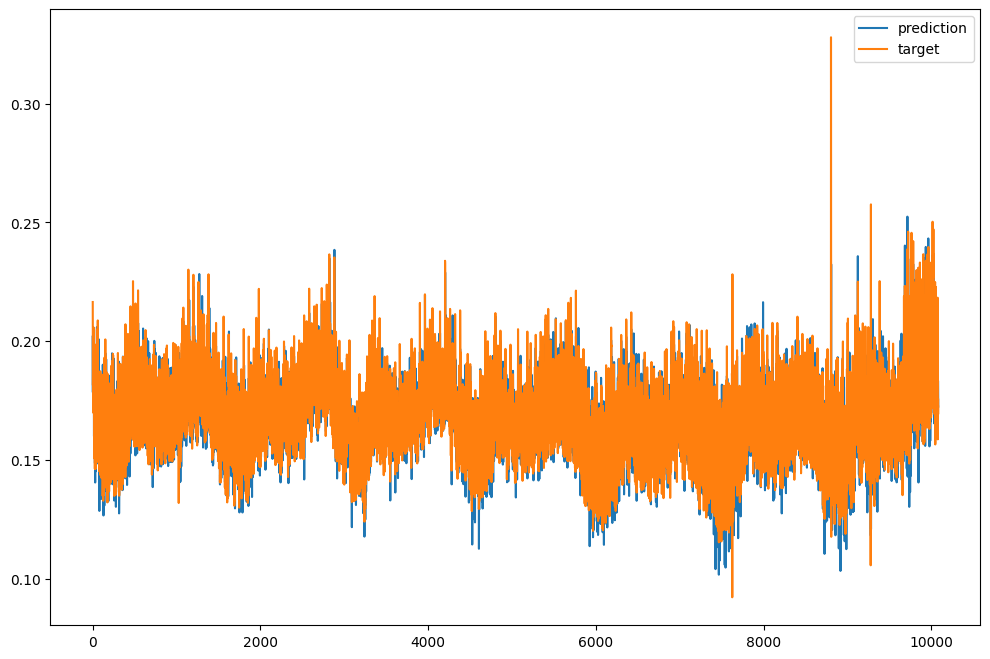

In [33]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [34]:
np.array(pred_list)

array([0.17890157, 0.20229   , 0.18311837, ..., 0.18335733, 0.17763814,
       0.17246029])

In [35]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [36]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [37]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.810592368245125 %
RMSE 0.008929550647735596
MAPE 3.8149502128362656 %


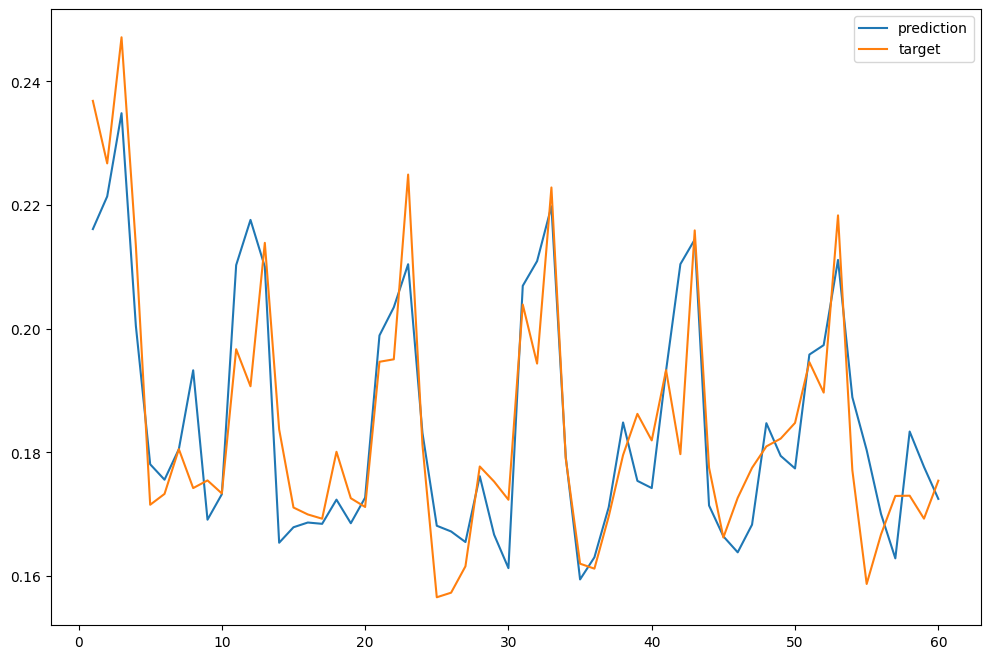

In [38]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [39]:
len(time_list)

10080

In [40]:
np.mean(time_list) 

0.289652325567745